In [1]:
from victim_circuit_gen import victim_gen
from helper import circuit_runtime_in_ms

In [2]:
from qiskit import QuantumCircuit
from qiskit_ibm_provider import IBMProvider
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

import numpy as np
import matplotlib.pyplot as plt

from bisect import bisect


# Parameters

In [3]:
snooper_qubits = (1, 4, 6)
victim_qubits = (3, 5)
ibm_backend_name = 'ibm_nairobi'

max_circuit_depth = 50
cnot_vals = list(range(20))
no_of_circuits_per_cnot_val = 60

In [4]:
provider = IBMProvider()
backend = provider.get_backend(ibm_backend_name)

# Methods

In [5]:
def init_snoopers(num_of_snoopers):
    '''
        num_of_snoopers: # of snooper qubits
        create a barrier after this and then add the victim qc
    '''
    qc = QuantumCircuit(num_of_snoopers)
    qc.h(range(num_of_snoopers))
    return qc

def readout_snoopers(num_of_snoopers):
    '''
        num_of_snoopers: # of snooper qubits
        create a barrier before this
    '''
    qc = QuantumCircuit(num_of_snoopers)
    qc.h(range(num_of_snoopers))
    qc.measure_all()
    return qc

# Create victim circuits

In [ ]:
victim_qcs = []
for no_of_cnots in cnot_vals:
    for _ in range(no_of_circuits_per_cnot_val):
        victim_qc = victim_gen.random_2_qubit_circuit_one_way_cnot(no_of_cnots, np.random.randint(no_of_cnots, max_circuit_depth))
        victim_qcs.append(victim_qc)

## Create full circuit for IBM Backend

In [ ]:
qc1 = init_snoopers(len(snooper_qubits))
qc2 = readout_snoopers(len(snooper_qubits))

In [ ]:
qcs: list[QuantumCircuit] = []
for victim_qc in victim_qcs:
    qc = QuantumCircuit(backend.num_qubits, len(snooper_qubits))
    qc.append(qc1, snooper_qubits)
    qc.barrier()
    qc.append(victim_qc, victim_qubits)
    qc.barrier()
    qc.append(qc2, snooper_qubits, range(len(snooper_qubits)))
    qcs.append(qc.decompose())

In [ ]:
pm = generate_preset_pass_manager(0, backend)

In [ ]:
tqcs = pm.run(qcs)
job = backend.run(tqcs, shots=8000)
job.update_tags(['snooping', 'one_way_cnot'])
print('New job: ', job.job_id())

# Checkpoint

In [6]:
job_id = 'cgc7scc87iti7tpf2390'
job = provider.backend.retrieve_job(job_id)

## Analyse Results

In [7]:
tqcs = job.circuits()
qc_res_counts = job.result().get_counts()

In [8]:
import os
results_path = 'results/{}/{}'.format(job.backend().name, job.job_id())
if not os.path.exists(results_path):
   os.makedirs(results_path)

In [9]:
path = '{}/histograms'.format(results_path)
if not os.path.exists(path):
    os.makedirs(path)
    for cnot_count in cnot_vals:
        start_index = cnot_count*no_of_circuits_per_cnot_val
        data = qc_res_counts[start_index: start_index+no_of_circuits_per_cnot_val]
        title='CNOTs-{}'.format(cnot_count)
        fig, axs = plt.subplots()
        plot_histogram(data, ax=axs, title=title)
        fig.savefig('{}/{}.png'.format(path, title))
        plt.close(fig)

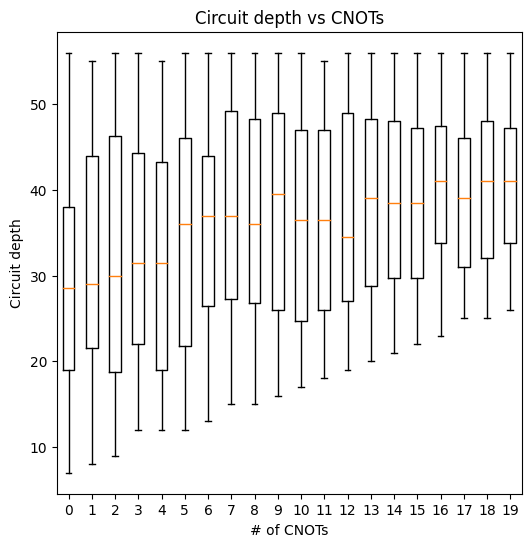

In [10]:
depths_per_cnots = []
for cnot_count in cnot_vals:
    start_index = cnot_count*no_of_circuits_per_cnot_val
    depths = []
    for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
        depths.append(tqcs[i].depth())
    depths_per_cnots.append(depths)

fig, axs = plt.subplots(figsize=(6, 6))
title = 'Circuit depth vs CNOTs'
axs.set_title(title)
axs.set_ylabel('Circuit depth')
axs.set_xlabel('# of CNOTs')
axs.boxplot(depths_per_cnots, labels=cnot_vals)
plt.show(fig)

fname = '{}/{}.png'.format(results_path, title)

if not os.path.isfile(fname):
    fig.savefig(fname)

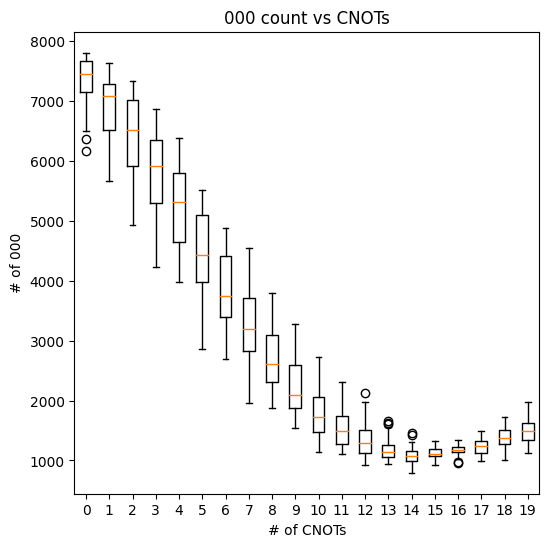

In [11]:
zero_counts_per_cnots = []
for cnot_count in cnot_vals:
    start_index = cnot_count*no_of_circuits_per_cnot_val
    zero_counts = []
    for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
        zero_counts.append(qc_res_counts[i]['000'])
    zero_counts_per_cnots.append(zero_counts)

fig, axs = plt.subplots(figsize=(6, 6))
title = '000 count vs CNOTs'
axs.set_title(title)
axs.set_ylabel('# of 000')
axs.set_xlabel('# of CNOTs')
axs.boxplot(zero_counts_per_cnots, labels=cnot_vals)
plt.show(fig)

fname = '{}/{}.png'.format(results_path, title)

if not os.path.isfile(fname):
    fig.savefig(fname)

## Analyse Results with binning

In [12]:
circuit_run_times_in_ms = []
for cnot_count in cnot_vals:
    start_index = cnot_count*no_of_circuits_per_cnot_val
    for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
        circuit_run_times_in_ms.append(circuit_runtime_in_ms(tqcs[i], backend))

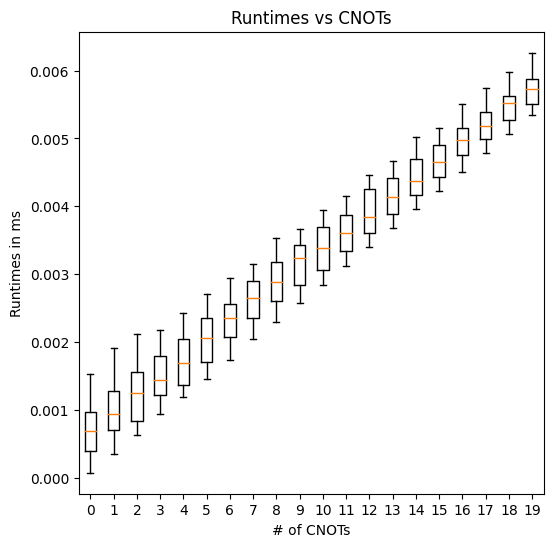

In [13]:
runtimes_per_cnots = []
for cnot_count in cnot_vals:
    start_index = cnot_count*no_of_circuits_per_cnot_val
    runtimes_per_cnots.append(circuit_run_times_in_ms[start_index: start_index+no_of_circuits_per_cnot_val])

fig, axs = plt.subplots(figsize=(6, 6))
title = 'Runtimes vs CNOTs'
axs.set_title(title)
axs.set_ylabel('Runtimes in ms')
axs.set_xlabel('# of CNOTs')
axs.boxplot(runtimes_per_cnots, labels=cnot_vals)
plt.show(fig)

fname = '{}/{}.png'.format(results_path, title)

if not os.path.isfile(fname):
    fig.savefig(fname)

In [14]:
thresholds = [0.002, 0.004, float('inf')]
batches = []
for t in thresholds:
    batches.append(set())

In [15]:
for i, time in enumerate(circuit_run_times_in_ms):
    x = bisect(thresholds, time)
    batches[x].add(i)

In [16]:
for b in batches:
    print(len(b))

315
465
420


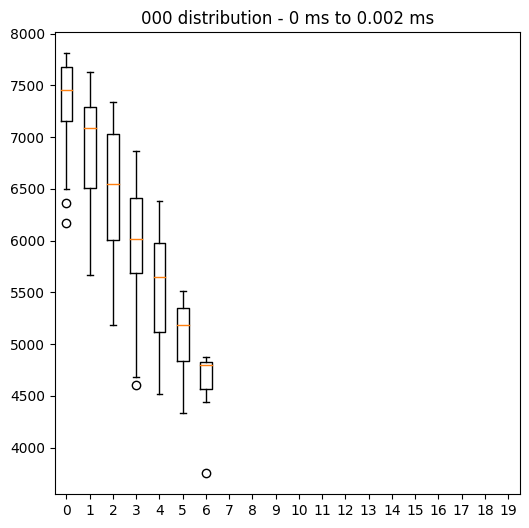

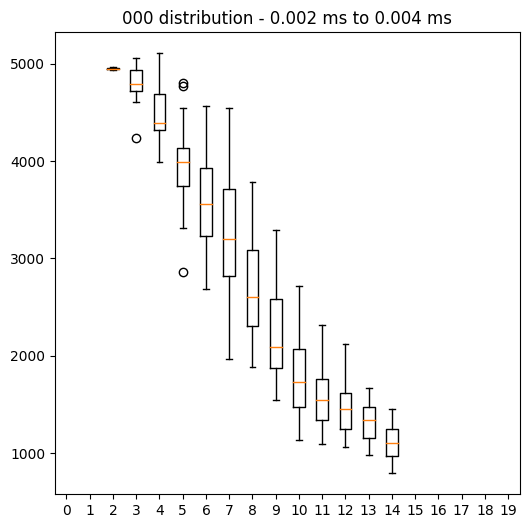

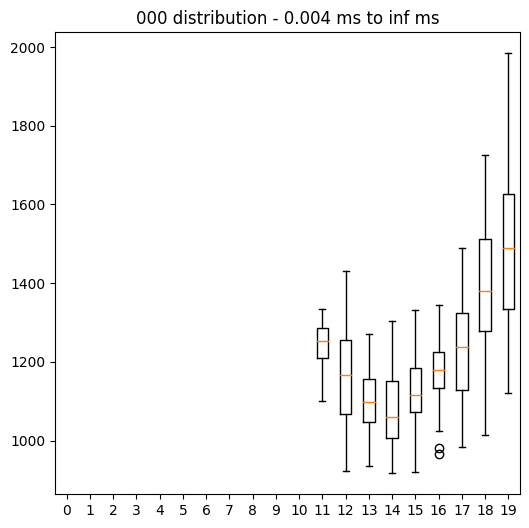

In [17]:
for j, b in enumerate(batches):
    dataa = []
    for cnot_count in cnot_vals:
        start_index = cnot_count*no_of_circuits_per_cnot_val
        data = []
        for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
            if i in batches[j]:
                data.append(qc_res_counts[i]['000'])
        dataa.append(data)

    fig, axs = plt.subplots(figsize=(6, 6))
    title = '000 distribution - {} ms to {} ms'.format(thresholds[j-1] if j!=0 else 0, thresholds[j])
    axs.set_title(title)
    axs.boxplot(dataa, labels=cnot_vals)

    

    plt.show(fig)
    
    fname = '{}/{}.png'.format(results_path, title)

    if not os.path.isfile(fname):
        fig.savefig(fname)
    

# Splitting results

In [18]:
split_res_counts = [[] for _ in range(3)]

for res_count in qc_res_counts:
    counts = [{'0': 0, '1': 0} for _ in range(3)]
    for key, count in res_count.items():
        for i, b in enumerate(key):
            counts[i][b] += count
    for c in range(len(counts)):
        split_res_counts[c].append(counts[c])

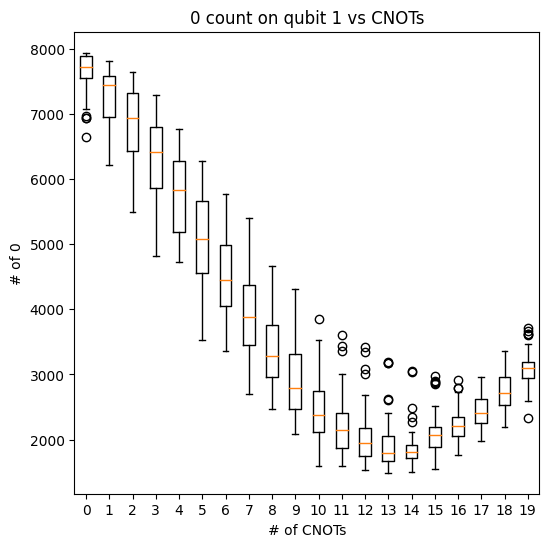

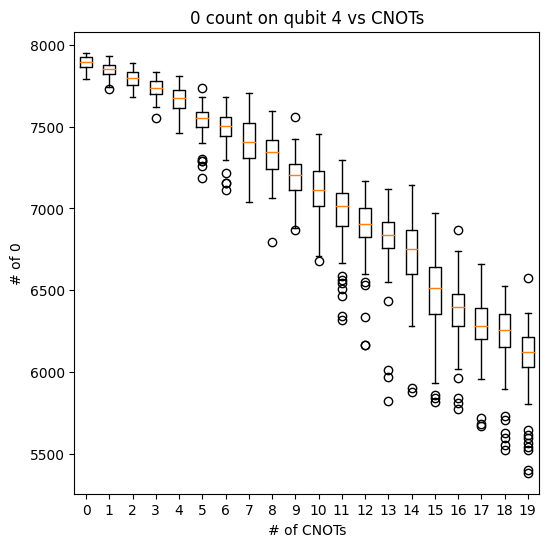

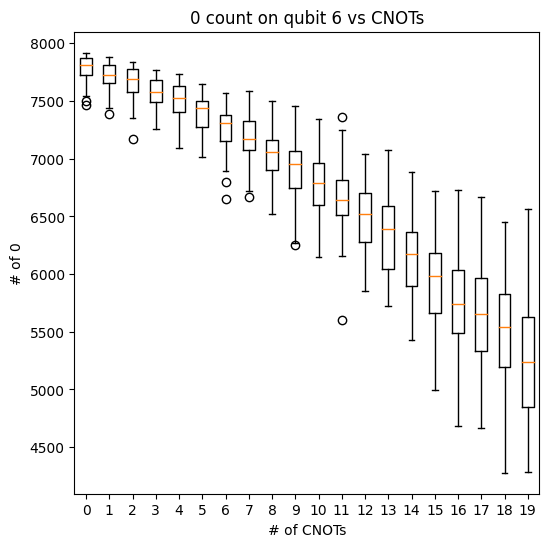

In [34]:
for qubit_index, res_counts in enumerate(split_res_counts):
    zero_counts_per_cnots = []
    for cnot_count in cnot_vals:
        start_index = cnot_count*no_of_circuits_per_cnot_val
        zero_counts = []
        for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
            zero_counts.append(res_counts[i]['0'])
        zero_counts_per_cnots.append(zero_counts)

    fig, axs = plt.subplots(figsize=(6, 6))
    title = '0 count on qubit {} vs CNOTs'.format(snooper_qubits[qubit_index])
    axs.set_title(title)
    axs.set_ylabel('# of 0')
    axs.set_xlabel('# of CNOTs')
    axs.boxplot(zero_counts_per_cnots, labels=cnot_vals)
    plt.show(fig)

    fname = '{}/{}.png'.format(results_path, title)

    if not os.path.isfile(fname):
        fig.savefig(fname)

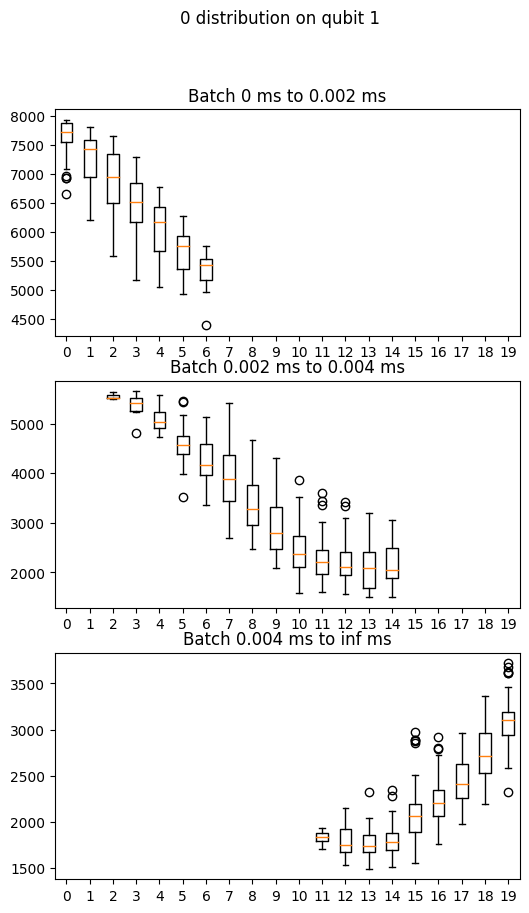

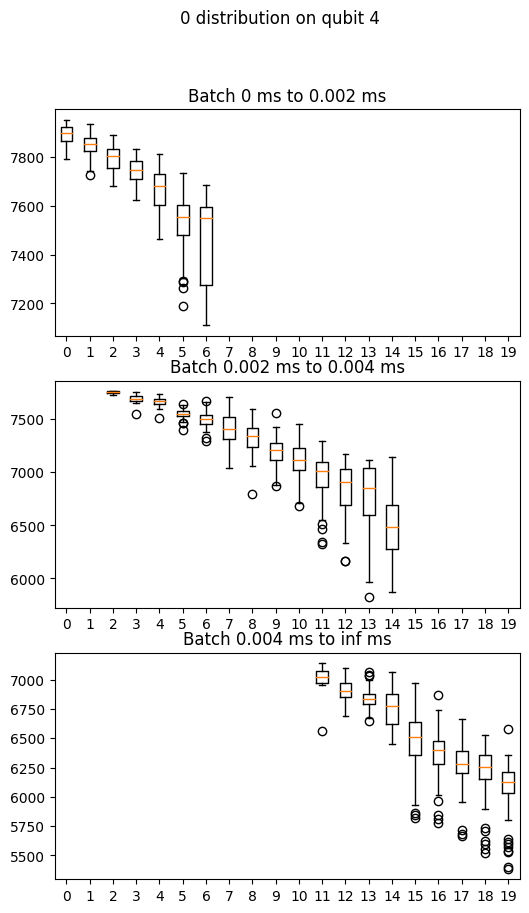

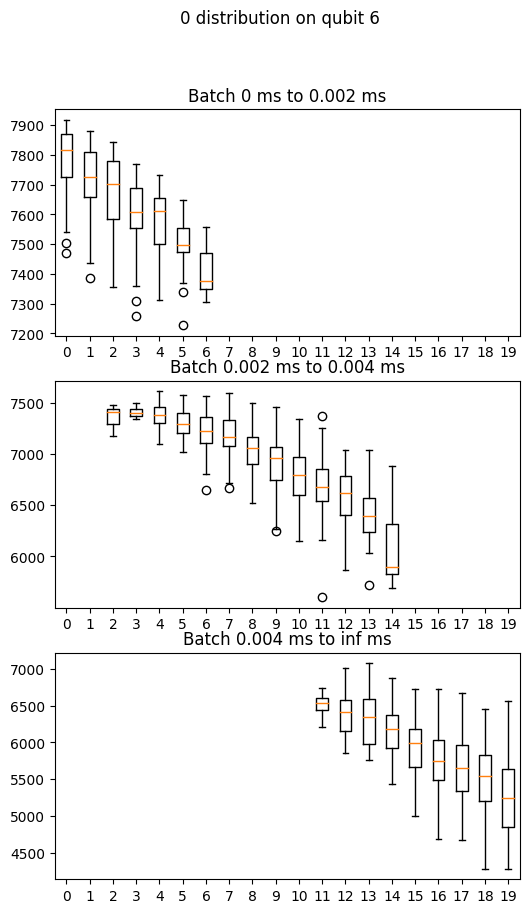

In [33]:
for qubit_index, res_counts in enumerate(split_res_counts):
    fig, axs = plt.subplots(len(batches), figsize=(6, 10))
    title = '0 distribution on qubit {}'.format(snooper_qubits[qubit_index])
    fig.suptitle(title)
    for j, b in enumerate(batches):
        dataa = []
        for cnot_count in cnot_vals:
            start_index = cnot_count*no_of_circuits_per_cnot_val
            data = []
            for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
                if i in batches[j]:
                    data.append(split_res_counts[qubit_index][i]['0'])
            dataa.append(data)
        axs[j].boxplot(dataa, labels=cnot_vals)
        axs[j].set_title('Batch {} ms to {} ms'.format(thresholds[j-1] if j!=0 else 0, thresholds[j]))
    plt.show(fig)
        
    fname = '{}/{}.png'.format(results_path, title)

    if not os.path.isfile(fname):
        fig.savefig(fname)
    